# TFIDF K-Means clustering on test data

Test K-Means clustering on 20newsgroups dataset. Tokens are vectorized using TF-IDF

In [34]:
# all imports go here
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import f1_score

import numpy as np
import pandas as pd

import re
import nltk
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import matplotlib.cm as cm

First, load in our dataset. For testing purposes, I will only use the technology, religion and sport category from the 20newsgroups dataset

In [2]:
categories = ['comp.graphics', 'comp.os.ms-windows.misc', 'rec.sport.baseball', 'rec.sport.hockey', 
              'alt.atheism', 'soc.religion.christian']
dataset = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, remove=('headers', 'footers', 'quotes'))

Peek dataset

In [3]:
for i in range(3):
    print('Sample {}:'.format(i))
    print(dataset['data'][i]+'\n')
    print('Lable {}: {} - {}'.format(i, dataset['target'][i], dataset['target_names'][dataset['target'][i]]))
    print('-----------------------------------------------------------------\n')

Sample 0:

They tried their best not to show it, believe me. I'm surprised they
couldn't find a sprint car race (mini cars through pigpens, indeed!)
on short notice.

George

Lable 0: 4 - rec.sport.hockey
-----------------------------------------------------------------

Sample 1:

Stankiewicz?  I doubt it.

Koufax was one of two Jewish HOFs: the other is Hank Greenberg.

Other good players: Buddy Myer, Johnny Kling, Norm and Larry Sherry,
Ken Holtzman, Saul Rogovin, Ed Reulbach.  

There have been over 150 Jewish major leaguers.  A few years ago there
was an article about someone who keeps track of this in Spy magazine;
the article was entitled "Jews on First," of course.

There have also been at least two books on the subject.

Lable 1: 3 - rec.sport.baseball
-----------------------------------------------------------------

Sample 2:

[deletia- and so on]

I seem to have been rather unclear.

What I was asking is this:

Please show me that the most effective substance-absure recover

In [4]:
df = pd.DataFrame()
df['corpus'], df['label'], df['label_name'] = [dataset.data, dataset.target, [dataset.target_names[target] for target in dataset.target]]
df.head()

,corpus,label,label_name
0,"\nThey tried their best not to show it, believ...",4,rec.sport.hockey
1,\nStankiewicz? I doubt it.\n\nKoufax was one ...,3,rec.sport.baseball
2,\n[deletia- and so on]\n\nI seem to have been ...,5,soc.religion.christian
3,"Excuse the sheer newbieness of this post, but ...",1,comp.graphics
4,==============================================...,1,comp.graphics


Clean and tokenize corpus

In [5]:
def preprocess_text(text: str) -> str:
    # remove links
    text = re.sub(r"http\S+", "", text)
    # remove special chars and numbers
    text = re.sub("[^A-Za-z]+", " ", text)
    # tokenize and remove stopwords
    tokens = nltk.word_tokenize(text)
    tokens = [w for w in tokens if not w.lower() in stopwords.words("english")]
    text = " ".join(tokens)
    text = text.lower().strip()
    return text

In [6]:
df['cleaned_corpus'] = df['corpus'].apply(lambda x: preprocess_text(x))
df.head()

,corpus,label,label_name,cleaned_corpus
0,"\nThey tried their best not to show it, believ...",4,rec.sport.hockey,tried best show believe surprised find sprint ...
1,\nStankiewicz? I doubt it.\n\nKoufax was one ...,3,rec.sport.baseball,stankiewicz doubt koufax one two jewish hofs h...
2,\n[deletia- and so on]\n\nI seem to have been ...,5,soc.religion.christian,deletia seem rather unclear asking please show...
3,"Excuse the sheer newbieness of this post, but ...",1,comp.graphics,excuse sheer newbieness post looking decent pa...
4,==============================================...,1,comp.graphics,


TF-IDF Vertorization

In [7]:
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.95)
# sparse matrix
vec = vectorizer.fit_transform(df['cleaned_corpus'])

K-Means Clustering

In [8]:
# since we know that there should be 3 categories
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(vec)

C:\Users\SegFault\anaconda3\envs\meta\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=3, random_state=42)

In [9]:
df['predicted_cluster_label'] = kmeans.labels_
df.head()

,corpus,label,label_name,cleaned_corpus,predicted_cluster_label
0,"\nThey tried their best not to show it, believ...",4,rec.sport.hockey,tried best show believe surprised find sprint ...,2
1,\nStankiewicz? I doubt it.\n\nKoufax was one ...,3,rec.sport.baseball,stankiewicz doubt koufax one two jewish hofs h...,2
2,\n[deletia- and so on]\n\nI seem to have been ...,5,soc.religion.christian,deletia seem rather unclear asking please show...,0
3,"Excuse the sheer newbieness of this post, but ...",1,comp.graphics,excuse sheer newbieness post looking decent pa...,1
4,==============================================...,1,comp.graphics,,2


Check the top 10 keywords for each cluster

In [12]:
def get_top_keywords(n_terms):
    """This function returns the keywords for each centroid of the KMeans"""
    df = pd.DataFrame(vec.todense()).groupby(kmeans.labels_).mean() # groups the TF-IDF vector by cluster
    terms = vectorizer.get_feature_names_out() # access tf-idf terms
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([terms[t] for t in np.argsort(r)[-n_terms:]])) # for each row of the dataframe, find the n terms that have the highest tf idf score
            
get_top_keywords(10)


Cluster 0
christians,say,think,bible,believe,jesus,one,would,people,god

Cluster 1
graphics,dos,know,use,program,anyone,files,file,thanks,windows

Cluster 2
good,last,like,games,would,year,one,think,team,game


By looking at the keywords we can see that cluster 0 is about religion news, cluster 1 is about technology news, and cluster 2 is about sport news. Now we can create a mapping between the original lable and the cluster predicted label

|Original label   |Label name   |Cluster label   |
|:---:|:---|:---|
|0   |alt.atheism   |0   |
|1   |comp.graphics   |1   |
|2   |comp.os.ms-windows.misc   |1  |
|3   |rec.sport.baseball   |2   |
|4   |rec.sport.hockey   |2   |
|5   |soc.religion.christian   |0   |

In [13]:
def map_label(origin_label):
    if origin_label == 0 or origin_label == 5:
        return 0
    elif origin_label == 1 or origin_label == 2:
        return 1
    else:
        return 2
df['cluster_label'] = df['label'].apply(lambda x: map_label(x))
df.head()

,corpus,label,label_name,cleaned_corpus,predicted_cluster_label,cluster_label
0,"\nThey tried their best not to show it, believ...",4,rec.sport.hockey,tried best show believe surprised find sprint ...,2,2
1,\nStankiewicz? I doubt it.\n\nKoufax was one ...,3,rec.sport.baseball,stankiewicz doubt koufax one two jewish hofs h...,2,2
2,\n[deletia- and so on]\n\nI seem to have been ...,5,soc.religion.christian,deletia seem rather unclear asking please show...,0,0
3,"Excuse the sheer newbieness of this post, but ...",1,comp.graphics,excuse sheer newbieness post looking decent pa...,1,1
4,==============================================...,1,comp.graphics,,2,1


Visualize some miss classification for each cluster

In [29]:
def vis_miss_classification(cluster_id):
    false_positive = df[(df['predicted_cluster_label']==cluster_id) & (df['cluster_label'] != df['predicted_cluster_label'])]
    false_negative = df[(df['cluster_label']==cluster_id) & (df['cluster_label'] != df['predicted_cluster_label'])]
    print('Cluster {} false positive'.format(cluster_id))
    for i in range(1):
        print(false_positive.iloc[i]['corpus'])
        print('Label: {}'.format(false_positive.iloc[i]['cluster_label']))
        print('Predict: {}'.format(false_positive.iloc[i]['predicted_cluster_label']))
    print('Cluster {} false negative'.format(cluster_id))
    for i in range(1):
        print(false_negative.iloc[i]['corpus'])
        print('Label: {}'.format(false_negative.iloc[i]['cluster_label']))
        print('Predict: {}'.format(false_negative.iloc[i]['predicted_cluster_label']))
vis_miss_classification(0)

Cluster 0 false positive


Are most players who come up young always good when they're young, or
later?


Damn.  I was afraid you would say that!


Well, perhaps if the Braves had no one else worth playing this year it
would be Lopez in there.  But they do have others worth playing, at
least in *their* opinion.  And I happen to agree.


I can believe that.  I'm a newbie here, so I'll take your word.  But
Alomar *is* a fine defensive catcher, which was my statement above.
That is a solid reason for bringing him up at a tender age, as long
as they feel he can also hit a bit.  Lopez does not have such a
consensus about his defensive prowess, and imho that is enough to
give him that dreaded "seasoning".


Sorry.  New.  Don't know Nichols' Law.  Don't believe in catchers'
era.  But I am interested in pitchers' eras with different catchers.
Any info on that?


In other words, we know more than they do, so the only logic behind 
a different decision than we would make must be financial.  I pr

In [30]:
vis_miss_classification(1)

Cluster 1 false positive
Would someone please give me the address for Texas Ranger
ticket orders. Thanks very much.
Label: 2
Predict: 1
Cluster 1 false negative

Label: 1
Predict: 2


In [31]:
vis_miss_classification(2)

Cluster 2 false positive

Label: 1
Predict: 2
Cluster 2 false negative
Would someone please give me the address for Texas Ranger
ticket orders. Thanks very much.
Label: 2
Predict: 1


Calculate F1 score

In [33]:
f1_score = f1_score(df['cluster_label'], df['predicted_cluster_label'], average='macro')
print(f1_score)

0.7796609030022735


# Find optimal number of Clusters

In this testing data set, we already know the number of clusters. However, in our project, we only have a very rough estimate of the number of categories. Therefore, we need to find a way to determine number of clusters. Here, I will use the 'elbow' method.

Fit 2 clusters
Fit 3 clusters
Fit 4 clusters
Fit 5 clusters
Fit 6 clusters
Fit 7 clusters
Fit 8 clusters
Fit 9 clusters
Fit 10 clusters


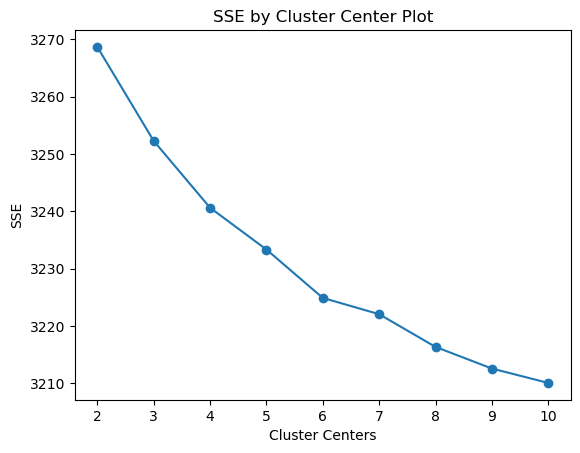

In [39]:
def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 1)
    
    sse = []
    for k in iters:
        sse.append(KMeans(n_clusters=k, random_state=42).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_clusters(vec, 10)

We can see that 6 should be the optimal number of clusters which matches our inital input data classes